In [1]:
import os, sys
if 'notebooks' not in os.listdir():
    os.chdir('..')

In [2]:
!nvidia-smi

Sat May  6 13:12:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8    16W / 380W |     85MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

from sparse.slinear2d import SLinear2d
from torch.nn import Linear
from torch import nn

from sparse.sconv2d import SConv2d

from torch.nn import Conv2d

import matplotlib.pyplot as plt

In [4]:
N = 1000
c_in, c_out = 2, 20
x = torch.randn((N, c_in, 64, 64))
print(x.shape)
print(x.mean(), x.std())

torch.Size([1000, 2, 64, 64])
tensor(0.0004) tensor(1.0001)


In [5]:
slinear = SLinear2d(c_in, c_out, (64, 64))
linear = Linear(c_in*64*64, c_out*64*64)

sconv = SConv2d(c_in, c_out, 3)
conv = Conv2d(c_in, c_out, 3)

out_shape: (14, 14)
out_size: 196
weight: 20 2 196
weight: torch.Size([196, 40])
False False False True
22 True
33 Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)


In [6]:
y = linear(x.view(N, -1)) * 2.
print(y.shape)
print(y.mean(), y.std())

torch.Size([1000, 81920])
tensor(-4.1535e-05, grad_fn=<MeanBackward0>) tensor(1.1548, grad_fn=<StdBackward0>)


In [7]:
y = slinear(x) * 2.
print(y.shape)
print(y.mean(), y.std())

torch.Size([1000, 20, 14, 14])
tensor(-0.0003, grad_fn=<MeanBackward0>) tensor(2.7849, grad_fn=<StdBackward0>)


In [8]:
y = conv(x) * 1.
print(y.shape)
print(y.mean(), y.std())

torch.Size([1000, 20, 62, 62])
tensor(-0.0281, grad_fn=<MeanBackward0>) tensor(0.5561, grad_fn=<StdBackward0>)


In [9]:
y = sconv(x) * 1.
print(y.shape)
print(y.mean(), y.std())


torch.Size([1000, 20, 62, 62])
tensor(-0.0007, grad_fn=<MeanBackward0>) tensor(0.6029, grad_fn=<StdBackward0>)


In [10]:
from sparse.flinear2d import FLinear2d

In [11]:
N = 1000
c_in, c_out = 3, 12
x = torch.randn((N, c_in, 64, 64))
print(x.shape)
print(x.mean(), x.std())

torch.Size([1000, 3, 64, 64])
tensor(-0.0001) tensor(1.0002)


In [12]:
flinear = FLinear2d(c_in, c_out, (64, 64), (32, 32))
linear = Linear(c_in*64*64, c_out*32*32)

#flinear.lin_U.weight.data = torch.sign(flinear.lin_U.weight.data) * torch.sqrt(flinear.lin_U.weight.data)
#flinear.lin_V.weight.data = torch.sign(flinear.lin_V.weight.data) * torch.sqrt(flinear.lin_V.weight.data)

In [13]:
y = linear(x.view(N, -1)) * 2.
print(y.shape)
print(y.mean(), y.std())

torch.Size([1000, 12288])
tensor(0.0002, grad_fn=<MeanBackward0>) tensor(1.1550, grad_fn=<StdBackward0>)


In [14]:
print(x.mean(), x.std())
y = flinear(x)
print(y.shape)
print(y.mean(), y.std())

tensor(-0.0001) tensor(1.0002)
torch.Size([1000, 12, 32, 32])
tensor(-0.0044, grad_fn=<MeanBackward0>) tensor(1.0514, grad_fn=<StdBackward0>)


#### slinear

In [15]:
def plot_slinear(slinear):
    weightU = slinear.lin_U.weight_fn()
    print(1024, 'U_out', slinear.lin_U.out_channels, 'U_in', slinear.lin_U.in_channels)
    print('U:', weightU.shape)
    weightU = weightU.view(c_out, c_in, 1024)
    print('U:', weightU.shape, weightU.std())

    weightV = slinear.lin_V.weight_fn()
    print('V:', weightV.shape)
    weightV = weightV.view(256, c_out, c_in)
    print('V:', weightV.shape)

    print(weightV.shape, weightV.std())

    plt.subplot(1, 2, 1)
    plt.imshow(weightU[0, 0, :].reshape(32, 32).detach())
    plt.subplot(1, 2, 2)
    plt.imshow(weightV[:, 0, 0].reshape(16, 16).detach())
    plt.show()

In [16]:
N = 2
c_in, c_out = 3, 16
x = torch.randn((N, c_in, 32, 32))
print(x.shape)
print(x.mean(), x.std())

torch.Size([2, 3, 32, 32])
tensor(0.0067) tensor(1.0103)


In [17]:
slinear = SLinear2d(c_in, c_out, (32, 32), (16, 16))

y = slinear(x)
print('y1:', y.shape)
print('y1:', y.mean(), y.std())

out_shape: (16, 16)
out_size: 256
weight: 16 3 256
weight: torch.Size([256, 48])
y1: torch.Size([2, 16, 16, 16])
y1: tensor(-0.0217, grad_fn=<MeanBackward0>) tensor(1.3427, grad_fn=<StdBackward0>)


In [18]:
weightU = slinear.lin_U.weight_fn()
print(weightU.shape, weightU.std())

weightV = slinear.lin_V.weight_fn()
print(weightV.shape, weightV.std())

torch.Size([16, 3072]) tensor(0.0310, grad_fn=<StdBackward0>)
torch.Size([256, 48]) tensor(0.8153, grad_fn=<StdBackward0>)


1024 U_out 16 U_in 3
U: torch.Size([16, 3072])
U: torch.Size([16, 3, 1024]) tensor(0.0310, grad_fn=<StdBackward0>)
V: torch.Size([256, 48])
V: torch.Size([256, 16, 3])
torch.Size([256, 16, 3]) tensor(0.8153, grad_fn=<StdBackward0>)


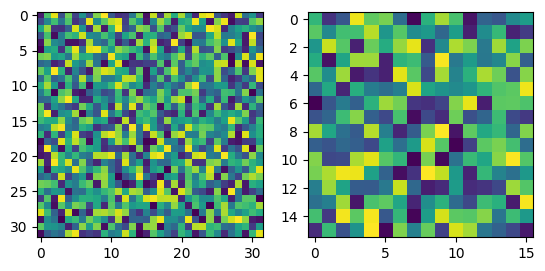

In [19]:
plot_slinear(slinear)

In [20]:

slinear.reduce(0.5)

y = slinear(x)
print('y2:', y.shape)
print('y2:', y.mean(), y.std())

W1 tensor(-0.0002, grad_fn=<MeanBackward0>) tensor(0.0310, grad_fn=<StdBackward0>)
W2 tensor(-0.0002, grad_fn=<MeanBackward0>) tensor(0.0221, grad_fn=<StdBackward0>)
y2: torch.Size([2, 16, 16, 16])
y2: tensor(0.0015, grad_fn=<MeanBackward0>) tensor(0.6442, grad_fn=<StdBackward0>)


1024 U_out 16 U_in 3
U: torch.Size([16, 3072])
U: torch.Size([16, 3, 1024]) tensor(0.0221, grad_fn=<StdBackward0>)
V: torch.Size([256, 48])
V: torch.Size([256, 16, 3])
torch.Size([256, 16, 3]) tensor(0.5830, grad_fn=<StdBackward0>)


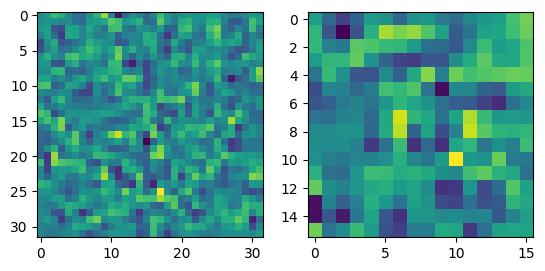

In [21]:
plot_slinear(slinear)